# 1. Overview

The code here implements a fully-connected feedforward network from scratch. It is based on material covered in the *DeepLearning.AI* [Deep Learning Specialization](https://www.deeplearning.ai/courses/deep-learning-specialization/), and is loosely inspired by the `Keras` neural network implementation for the coding architecture.

Capabilities implemented so far:

* Layer types:
    * Dense (only layer type supported so far)
        * Weight initializations:
            1. Xavier
            2. He
        * Batch normalization (option within the layer)
* Activation functions:
    * ReLU
    * Leaky ReLU
    * Tanh
    * Sigmoid
    * Linear (identity)
    * Softmax
* Loss functions and evaluation metrics:
    * Binary cross-entropy (both)
    * Categorical cross-entropy (both)
    * Mean squared error (both)
    * Accuracy (only as an evaluation metric)
* Regularization methods:
    * L2
    * Dropout
    * Early stopping
* Optimization:
    * Mini-batches
    * Momentum
    * RMSprop
    * Adam
    * Learning rate decay
* Evaluation on a validation set supported
* A gradient-checking function to verify the validity of the gradient descent implementation

# 2. Model Construction

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification, make_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import copy
from abc import ABC, abstractmethod

In [2]:
# --------------------------------------------
#          Activation Functions
# --------------------------------------------
class Activations(ABC):
    @staticmethod
    @abstractmethod
    def activate(x):
        pass
    @staticmethod
    @abstractmethod
    def derivative(x):
        pass
class relu(Activations):
    @staticmethod
    def activate(x):
        return np.maximum(x, 0)
    @staticmethod
    def derivative(x):
        return np.where(x >= 0, 1, 0)
class leakyrelu(Activations):
    @staticmethod
    def activate(x):
        return np.where(x >= 0, x, 0.01*x)
    @staticmethod
    def derivative(x):
        return np.where(x >= 0, 1, 0.01)
class sigmoid(Activations):
    @staticmethod
    def activate(x):
        return 1 / (1 + np.exp(-x))
    @staticmethod
    def derivative(x):
        return sigmoid.activate(x) * (1 - sigmoid.activate(x))
class tanh(Activations):
    @staticmethod
    @np.vectorize
    def activate(x):
        return np.math.tanh(x)
    @staticmethod
    @np.vectorize
    def derivative(x):
        return 1 - np.math.tanh(x) ** 2
class softmax(Activations):
    @staticmethod
    def activate(x):
        vec = np.exp(x)
        return vec / vec.sum(axis = 0)
    @staticmethod
    def derivative(x):
        return softmax.activate(x) * (1 - softmax.activate(x))
class linear(Activations):
    @staticmethod
    def activate(x):
        return x
    @staticmethod
    def derivative(x):
        return 1

# --------------------------------------------
#    Evaluation Metrics and Loss Functions
# --------------------------------------------
class Metrics(ABC):
    @staticmethod
    @abstractmethod
    def score(y, preds):
        pass
class LossFunctions(Metrics):
    @abstractmethod
    def dJdA(self, y, preds):
        pass
class Accuracy(Metrics):
    @staticmethod
    def score(y, preds, threshold = 0.5):
        return np.mean((preds >= threshold) - y == 0)
class BinaryCrossentropy(LossFunctions):
    @staticmethod
    def score(y, preds):
        return -np.mean(y * np.log(preds) + (1 - y) * np.log(1 - preds))
    def dJdA(self, y, preds):
        return -(y/preds) + (1-y) / (1-preds)
class CategoricalCrossentropy(LossFunctions):
    @staticmethod
    def score(y, preds):
        return -(y * np.log(preds)).sum(axis = 1).mean()
    def dJdA(self, y, preds):
        return -y/preds
class MeanSquaredError(LossFunctions):
    @staticmethod
    def score(y, preds):
        return ((y - preds) ** 2).mean()
    def dJdA(self, y, preds):
        return -2 * (y - preds)

# --------------------------------------------
#          Optimization Methods
# --------------------------------------------
class Optimizers(ABC):
    @abstractmethod
    def _update_accumulators(self, layer):
        pass
    @abstractmethod
    def _gen_update_quantity(self, layer, attr, num_iterations):
        pass
class GradientDescent(Optimizers):
    def __init__(self, momentum = 0.9):
        self.momentum = momentum
    def _update_accumulators(self, layer):
        for param in ['W', 'b', 'gamma', 'beta']:
            if hasattr(layer, param):
                getattr(layer, param).Vdx -= ((1 - self.momentum)
                                                     * (getattr(layer, param).Vdx - getattr(layer, param).d))
    def _gen_update_quantity(self, layer, param, num_iterations):
        return getattr(layer, param).Vdx
class RMSprop(Optimizers):
    def __init__(self, beta = 0.999, epsilon = 1e-8):
        self.beta = beta
        self.epsilon = epsilon
    def _update_accumulators(self, layer):
        for param in ['W', 'b', 'gamma', 'beta']:
            if hasattr(layer, param):
                getattr(layer, param).Sdx -= ((1 - self.beta)
                                                     * (getattr(layer, param).Sdx - getattr(layer, param).d**2))
    def _gen_update_quantity(self, layer, param, num_iterations):
        return getattr(layer, param).d / (getattr(layer, param).Sdx ** 0.5 + self.epsilon)
class Adam(Optimizers):
    def __init__(self, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-8):
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.epsilon = epsilon
    def _update_accumulators(self, layer):
        for param in ['W', 'b', 'gamma', 'beta']:
            if hasattr(layer, param):
                getattr(layer, param).Vdx -= ((1 - self.beta_1)
                                                     * (getattr(layer, param).Vdx - getattr(layer, param).d))
                getattr(layer, param).Sdx -= ((1 - self.beta_2)
                                                     * (getattr(layer, param).Sdx - getattr(layer, param).d**2))
    def _gen_update_quantity(self, layer, param, num_iterations):
        Vdx_corrected = getattr(layer, param).Vdx / (1 - self.beta_1 ** num_iterations)
        Sdx_corrected = getattr(layer, param).Sdx / (1 - self.beta_2 ** num_iterations)
        return Vdx_corrected / (Sdx_corrected ** .5 + self.epsilon)

# --------------------------------------------
#                 Layers
# --------------------------------------------
class Dense:
    
    def __init__(self,  shape, activation = linear(), weight_initialization = None, dropout = 0.0,
                 batch_normalization = False, epsilon_BN = None):
        self.nl = shape[0]
        self.activation = activation
        self.nl_1 = shape[1]
        self.dropout = dropout
        self.batch_normalization = batch_normalization
        if batch_normalization is True:
            if epsilon_BN is None:
                self.epsilon_BN = 1e-5
            else:
                self.epsilon_BN = epsilon_BN
        
        if weight_initialization in ['Xavier', 'He']:
            self.weight_initialization = weight_initialization
        elif weight_initialization is None:
            self.weight_initialization = self._set_default_initializer(activation)
        else:
            raise ValueError('Initialization method not supported')
        
        if self.weight_initialization == 'Xavier':
            self.W = self._ParamsAndAccumulators(self._Xavier_initialization(self.nl, self.nl_1))
        elif self.weight_initialization == 'He':
            self.W = self._ParamsAndAccumulators(self._He_initialization(self.nl, self.nl_1))
        
        if self.batch_normalization is False:
            self.b = self._ParamsAndAccumulators(np.zeros((self.nl,1)))
        else:
            self.gamma = self._ParamsAndAccumulators(np.ones((self.nl,1)))
            self.beta = self._ParamsAndAccumulators(np.zeros((self.nl,1)))
            self.population_mu = np.zeros((self.nl,1))
            self.population_sigma2 = np.zeros((self.nl,1))
            self.population_momentum = 0.99
    
    def _layer_forwardprop(self, prev_layer, training, X):
        if self.batch_normalization is False:
            self.Z = self.W.params @ prev_layer.A + self.b.params
            self.A = self.activation.activate(self.Z)
            if training is True:
                inverted_dropout_mask = ((np.random.rand(self.A.shape[0], self.A.shape[1]) > self.dropout)
                                               / (1 - self.dropout))
                self.A *= inverted_dropout_mask
        else:
            self._layer_forwardprop_BN(prev_layer, training, X)
    
    def _layer_backprop(self, X, y, loss, optimizer, prev_layer, next_layer = None):
        if self.batch_normalization is False:
            if next_layer is None:  # i.e. we're in the output layer
                self.dA = loss.dJdA(y.T, self.A)
            else:
                self.dA = next_layer.W.params.T @ next_layer.dZ
            self.dZ = self.dA * self.activation.derivative(self.Z)
            self.W.d = (self.dZ @ prev_layer.A.T) / X.shape[0]
            self.b.d = self.dZ.mean(axis = 1, keepdims = True)
            optimizer._update_accumulators(self)
        else:
            self._layer_backprop_BN(X, y, loss, optimizer, prev_layer, next_layer)
    
    def _layer_forwardprop_BN(self, prev_layer, training, X):
        self.Z = self.W.params @ prev_layer.A
        if training is True:
            self.mu = self.Z.mean(axis = 1, keepdims = True)
            self.sigma2 = self.Z.var(axis = 1, keepdims = True)
            self.population_mu -= (1 - self.population_momentum) * (self.population_mu - self.mu)
            self.population_sigma2 -= (1 - self.population_momentum) * (self.population_sigma2 - self.sigma2)
        else:
            self.mu = self.population_mu
            self.sigma2 = self.population_sigma2
        self.Znorm = (self.Z - self.mu) / (self.sigma2 + self.epsilon_BN)**0.5
        self.Ztilde = self.Znorm * self.gamma.params + self.beta.params
        self.A = self.activation.activate(self.Ztilde)
        if training is True:
            inverted_dropout_mask = ((np.random.rand(self.A.shape[0], self.A.shape[1]) > self.dropout)
                                           / (1 - self.dropout))
            self.A *= inverted_dropout_mask
    
    def _layer_backprop_BN(self, X, y, loss, optimizer, prev_layer, next_layer = None):
        if next_layer is None:  # i.e. we're in the output layer
            self.dA = loss.dJdA(y.T, self.A)
        else:
            self.dA = next_layer.W.params.T @ next_layer.dZ
        self.dZtilde = self.dA * self.activation.derivative(self.Ztilde)
        self.dZnorm = self.dZtilde * self.gamma.params
        self.dsigma2 = -0.5 * (self.sigma2 + self.epsilon_BN)**(-3/2) * (self.dZnorm * (self.Z - self.mu)).sum(axis = 1, keepdims = True)
        self.dmu = - self.dZnorm.sum(axis = 1, keepdims = True) * (self.sigma2 + self.epsilon_BN)**-0.5
        self.dZ = (self.dZnorm * (self.sigma2 + self.epsilon_BN)**-0.5
                       + self.dsigma2 * 2 * (self.Z - self.mu) / X.shape[0]
                       + self.dmu / X.shape[0])
        self.gamma.d = (self.dZtilde * self.Znorm).mean(axis = 1, keepdims = True)
        self.beta.d = self.dZtilde.mean(axis = 1, keepdims = True)
        self.W.d = (self.dZ @ prev_layer.A.T) / X.shape[0]
        optimizer._update_accumulators(self)
    
    def _set_default_initializer(self, activation):
        if activation in [relu(), leakyrelu()]:
            return 'He'
        else:
            return 'Xavier'
    
    def _Xavier_initialization(self, nl, nl_1):
        bound = (6 / (nl + nl_1)) ** 0.5
        return np.random.uniform(-bound, bound, size = (nl, nl_1))
    
    def _He_initialization(self, nl, nl_1):
        stdev = (2 / nl_1) ** 0.5
        return np.random.normal(scale = stdev, size = (nl, nl_1))
    
    def _initialize_accumulators(self):
        pass

    class _ParamsAndAccumulators():
        def __init__(self, params):
            self.params = params
            self.Vdx = np.zeros_like(params)
            self.Sdx = np.zeros_like(params)

In [3]:
class MLP:
    
    def __init__(self, loss = BinaryCrossentropy(), metric = Accuracy(), restore_best = True, l2_reg = 0.0,
                 input_dropout = 0.0, input_normalization = True):
        self.layers = []
        self.loss = loss
        self.metric = metric
        self.restore_best = restore_best
        self.l2_reg = l2_reg
        self.input_dropout = input_dropout
        self.input_normalization = input_normalization
        if type(loss) not in [BinaryCrossentropy, MeanSquaredError, CategoricalCrossentropy]:
            raise ValueError('Loss not currently supported')
        if type(metric) not in [Accuracy, BinaryCrossentropy, MeanSquaredError, CategoricalCrossentropy]:
            raise ValueError('Metric not currently supported')
    
    def add(self, layer):
        self.layers.append(layer)
    
    def fit(self, X, y, epochs = 100, batch_size = 32, earlyStopping = None, validation_split = 0.0,
            lr = 0.01, decay_rate = 0.1, optimizer = Adam()):
        
        self.validation_split = validation_split
        X_train, X_dev, y_train, y_dev = self._custom_train_test_split(X, y, validation_split)
        
        if self.input_normalization is True:
            self.normalizer = StandardScaler().fit(X_train)
        
        self.optimizer = optimizer
        self.history = self._History()
        self.epochs = 0
        self.stopper = 0  # increment until the early stopping value
        
        for i in range(epochs):
            self._minibatch_gradientdescent(X, y, batch_size, lr, decay_rate)
            self.epochs += 1
            self.history.train_score.append(self.score(X_train, y_train))
            if validation_split > 0:
                self.history.dev_score.append(self.score(X_dev, y_dev))
            
            self._check_earlyStopping()
            if self.restore_best == True:
                self._cache_best()
            if earlyStopping is not None:
                if self.stopper == earlyStopping:
                    break
                    
        del self.stopper
        if self.restore_best is True:
            self._restore_best_weights()
    
    def predict(self, X, _training = False):  # training argument for development purposes only
        self._net_forwardprop(X, _training)
        preds = self.layers[-1].A.T
        return preds
    
    def score(self, X, y):
        preds = self.predict(X)
        return self.metric.score(y, preds)
    
    def _custom_train_test_split(self, X, y, validation_split):
        if validation_split < 0 or validation_split >= 1:
            raise ValueError('Validation split should be in the range [0,1) (0 results in no validation set)')
        indices = np.random.permutation(len(X))
        train_size = round(len(X) * (1 - validation_split))
        self.train_indices = indices[:train_size]
        X_train = X[self.train_indices]
        y_train = y[self.train_indices]
        X_dev = X[indices[train_size:]]
        y_dev = y[indices[train_size:]]
        return X_train, X_dev, y_train, y_dev
    
    def _minibatch_gradientdescent(self, X, y, batch_size, lr, decay_rate):
        num_batches = np.ceil(len(self.train_indices) / batch_size)
        num_iterations = self.epochs * num_batches
        for i in np.arange(0, len(self.train_indices), batch_size):
            num_iterations += 1
            minibatch = self.train_indices[i : (i + batch_size)]
            mini_X, mini_y = X[minibatch], y[minibatch]
            self._net_forwardprop(mini_X, training = True)
            self._net_backprop(mini_X, mini_y)
            self._update_params(mini_X.shape[0], lr, decay_rate, num_iterations)
    
    def _net_forwardprop(self, X, training):
        if self.input_normalization is True:
            X = self.normalizer.transform(X)
        self.layers.insert(0, self._InputLayer(A = X.T, nl = X.shape[1]))
        if training is True:
            inverted_dropout_mask = ((np.random.rand(X.T.shape[0], X.T.shape[1]) > self.input_dropout)
                                           / (1 - self.input_dropout))
            self.layers[0].A *= inverted_dropout_mask
        for l, layer in enumerate(self.layers[1:], start = 1):
            layer._layer_forwardprop(self.layers[l-1], training, X)
        self.layers.pop(0)
    
    def _net_backprop(self, X, y):
        if self.input_normalization is True:
            X = self.normalizer.transform(X)
        self.layers.insert(0, self._InputLayer(A = X.T, nl = X.shape[1]))
        # Output layer's gradients and accumulators
        self.layers[-1]._layer_backprop(X, y, self.loss, self.optimizer, self.layers[-2], next_layer = None)
        # Remaining layers' gradients and accumulators
        for l, layer in reversed(list(enumerate(self.layers[:-1]))):
            if isinstance(layer, self._InputLayer):
                break
            layer._layer_backprop(X, y, self.loss, self.optimizer, self.layers[l-1], self.layers[l+1])
        self.layers.pop(0)
    
    def _update_params(self, m, lr, decay_rate, num_iterations):
        for layer in self.layers:
            decayed_lr = lr / (1 + decay_rate * (self.epochs+1))
            for param in ['W', 'b', 'gamma', 'beta']:
                if hasattr(layer, param):
                    update_quantity = self.optimizer._gen_update_quantity(layer, param, num_iterations)
                    if param == 'W':
                        regularizer = self.l2_reg / m
                    else:
                        regularizer = 0
                    getattr(layer, param).params -= (decayed_lr *
                                                            (update_quantity
                                                                 + regularizer * getattr(layer, param).params))
    
    def _check_earlyStopping(self):
        eval_fn = max if type(self.metric) in [Accuracy] else min
        if self.validation_split > 0:
            if self.history.dev_score[-1] == eval_fn(self.history.dev_score):
                self.stopper = 0
            else:
                self.stopper += 1
        else:
            if self.history.train_score[-1] == eval_fn(self.history.train_score):
                self.stopper = 0
            else:
                self.stopper += 1
    
    def _cache_best(self):
        if self.stopper == 0:
            for l, layer in enumerate(self.layers):
                self.history.best_params[l] = {}
                for param in ['W', 'b', 'gamma', 'beta']:
                    if hasattr(layer, param):
                        self.history.best_params[l][param] = getattr(layer, param).params
            if self.validation_split > 0:
                self.history.best_score = self.history.dev_score[-1]
            else:
                self.history.best_score = self.history.train_score[-1]
    
    def _restore_best_weights(self):
        for l, layer in enumerate(self.layers):
            for param in ['W', 'b', 'gamma', 'beta']:
                if hasattr(layer, param):
                    getattr(layer, param).params = self.history.best_params[l][param]
    
    class _InputLayer:
        def __init__(self, A, nl):
            self.A = A
            self.nl = nl
    
    class _History:
        def __init__(self, train_score = None, dev_score = None, best_params = None):
            if train_score is None:
                self.train_score = []
            if dev_score is None:
                self.dev_score = []
            if best_params is None:
                self.best_params = {}

# 3. Gradient Checking

In [4]:
def J(X, y, model, _training):
    yhat = model.predict(X, _training)
    base_loss = model.loss.score(y, yhat)
    reg_loss = sum([(layer.W.params**2).sum() for layer in model.layers]) * (model.l2_reg / (2*X.shape[0]))
    return base_loss + reg_loss

def gradient_approx(X, y, model, l, param, index, _training, epsilon=1e-7):
    tmp_model = copy.deepcopy(model)
    getattr(tmp_model.layers[l], param).params[index] += epsilon
    J1 = J(X, y, tmp_model, _training)
    getattr(tmp_model.layers[l], param).params[index] -= 2*epsilon
    J2 = J(X, y, tmp_model, _training)
    return (J1 - J2) / (2*epsilon)

def gradient_checking(X, y, model):
    results = []
    
    if sum([isinstance(layer.activation, softmax) for layer in model.layers]):  # i.e. if there exists a softmax layer
        raise Exception('Softmax not currently supported by this gradient checking implementation')
    if sum([layer.batch_normalization for layer in model.layers]) > 0:  # i.e., there exists a BN layer, and then we
                                                                        # don't want the averaged mus and sigmas
        training = True
        if sum([layer.dropout for layer in model.layers]) + model.input_dropout:
            raise Exception('Gradient checking not supported with both a batch norm layer and dropout together')
    else:
        training = False
    model._net_forwardprop(X, training = training)
    model._net_backprop(X, y)
    
    for l, layer in enumerate(model.layers):
        for index, dw in np.ndenumerate(layer.W.d):
            approximation = gradient_approx(X, y, model, l, 'W', index, _training=training)
            results.append([l,
                            'W',
                            index,
                            dw + layer.W.params[index] * (model.l2_reg / X.shape[0]),
                            approximation])
        
        for param in ['b', 'gamma', 'beta']:
            if hasattr(layer, param):
                for index, d in np.ndenumerate(getattr(layer, param).d):
                    approximation = gradient_approx(X, y, model, l, param, index, _training=training)
                    results.append([l, param, index, d, approximation])

    results = pd.DataFrame(results, columns = ['Layer', 'Param', 'Index', 'dtheta', 'dtheta_approx'])
    results['Difference'] = results['dtheta'] - results['dtheta_approx']
    
    normalized_distance = (np.linalg.norm(results['dtheta'] - results['dtheta_approx'])
                            / (np.linalg.norm(results['dtheta']) + np.linalg.norm(results['dtheta_approx'])))
    
    return normalized_distance

# 4. Classification and Regression Implementations

### Classification

In [5]:
X, y = make_classification(
    #random_state=42,   # Random seed for reproducibility
    n_samples=1000,   # Number of samples
    n_features=80,    # Number of features
    n_informative=50, # Number of informative features
    n_redundant=30,   # Number of redundant features
    n_classes=2,      # Number of classes
    flip_y=0.2,       # Fraction of samples whose class is assigned randomly
)
y = y.reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, shuffle = True)

In [6]:
model = MLP(l2_reg = 0.5, input_dropout=0.0)
model.add(Dense((32, 80), relu(), dropout=0.0, batch_normalization = True))
model.add(Dense((16, 32), leakyrelu(), dropout=0.0, batch_normalization = False))
model.add(Dense((4, 16), tanh(), dropout=0.0, batch_normalization = False))
model.add(Dense((1, 4), sigmoid()))

model.fit(X_train, y_train,
          epochs=1000,
          earlyStopping=20,
          validation_split = 1/9,
          lr = 0.001, decay_rate = 0.15)
print('Epochs:', model.epochs)

Epochs: 108


In [7]:
print('Train score:', round(max(model.history.train_score), 3))
print('Dev score:  ', model.history.best_score)
print('Test score: ', model.score(X_test, y_test))

Train score: 0.95
Dev score:   0.88
Test score:  0.85


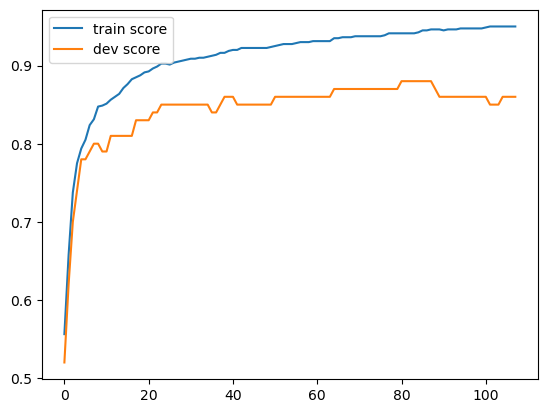

In [8]:
plt.plot(range(len(model.history.train_score)), model.history.train_score, label = 'train score')
plt.plot(range(len(model.history.dev_score)), model.history.dev_score, label = 'dev score')
plt.legend()
plt.show()

In [9]:
gradient_checking(X_train[:50], y_train[:50], model)

1.541541589002166e-08

### Regression

In [10]:
X, y = make_regression(
    #random_state=42,   # Random seed for reproducibility
    n_samples=1000,   # Number of samples
    n_features=80,    # Number of features
    n_informative=50, # Number of informative features
    noise=0.1         # SD of the gaussian noise applied to the output
)
y = y.reshape(-1,1)

#y = np.column_stack((y, y + 100 + X[:,1] * 30 - X[:,2] * 40 - X[:,3] ** 2))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, shuffle = True)

In [11]:
model = MLP(l2_reg = 1, loss = MeanSquaredError(), metric = MeanSquaredError())
model.add(Dense((32, 80), relu(), batch_normalization = True))
model.add(Dense((16, 32), leakyrelu()))
model.add(Dense((4, 16), leakyrelu()))
model.add(Dense((1, 4)))

model.fit(X_train, y_train,
          epochs=1000,
          earlyStopping=20,
          validation_split = 1/9,
          lr = 0.01,)
print('Epochs:', model.epochs)

Epochs: 32


In [12]:
print('Train score:', round(min(model.history.train_score), 3))
print('Dev score:  ', model.history.best_score)
print('Test score: ', model.score(X_test, y_test))

Train score: 1256.378
Dev score:   1836.2209195676594
Test score:  2582.1971402956733


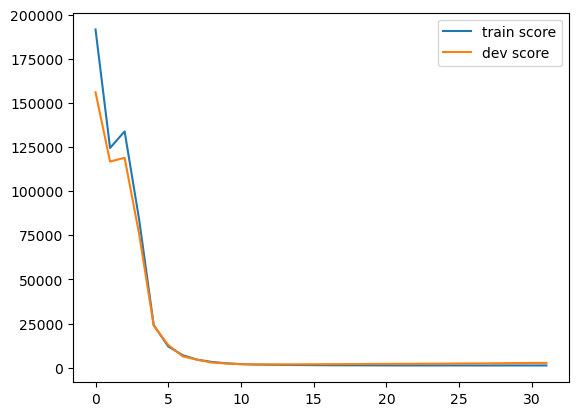

In [13]:
plt.plot(range(len(model.history.train_score)), model.history.train_score, label = 'train score')
plt.plot(range(len(model.history.dev_score)), model.history.dev_score, label = 'dev score')
plt.legend()
plt.show()

In [14]:
gradient_checking(X_train[:50], y_train[:50], model)

7.123840429095005e-09

### Multiclass Classification

In [20]:
X, y = make_classification(
    #random_state=42,   # Random seed for reproducibility
    n_samples=1000,   # Number of samples
    n_features=80,    # Number of features
    n_informative=50, # Number of informative features
    n_redundant=30,   # Number of redundant features
    n_classes=3,      # Number of classes
    flip_y=0.1,       # Fraction of samples whose class is assigned randomly
)
y = np.column_stack((y==0, y==1, y==2)).astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, shuffle = True)

In [21]:
model = MLP(l2_reg = 0.5, input_dropout=0.0, loss = CategoricalCrossentropy(), metric = CategoricalCrossentropy())
model.add(Dense((64, 80), relu(), dropout=0.0, batch_normalization = True))
model.add(Dense((32, 64), leakyrelu(), dropout=0.0, batch_normalization = True))
model.add(Dense((8, 32), tanh(), dropout=0.0, batch_normalization = True))
model.add(Dense((3, 8), softmax()))

model.fit(X_train, y_train,
          epochs=1000,
          earlyStopping=20,
          validation_split = 1/9,
          lr = 0.001, decay_rate = 0.15)
print('Epochs:', model.epochs)

Epochs: 35


In [22]:
print('Train score:', round(min(model.history.train_score), 3))
print('Dev score:  ', model.history.best_score)
print('Test score: ', model.score(X_test, y_test))

Train score: 0.297
Dev score:   0.7639834876033373
Test score:  0.8424153296868668


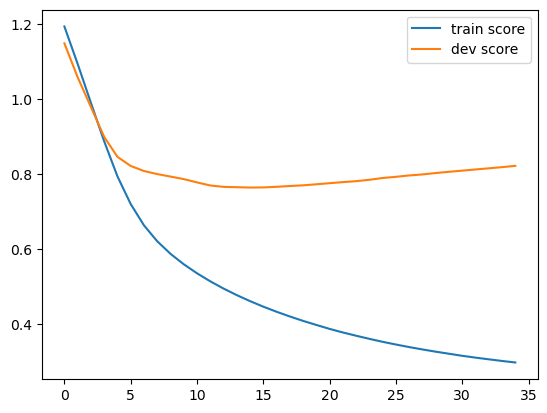

In [23]:
plt.plot(range(len(model.history.train_score)), model.history.train_score, label = 'train score')
plt.plot(range(len(model.history.dev_score)), model.history.dev_score, label = 'dev score')
plt.legend()
plt.show()

In [24]:
train_preds = model.predict(X_train[model.train_indices])
dev_preds = model.predict(X_train[~np.isin(np.arange(X_train.shape[0]), model.train_indices)])
test_preds = model.predict(X_test)
print(f'Correct train set classifications: {(((train_preds == train_preds.max(axis = 1).reshape(-1,1)) == y_train[model.train_indices]).sum(axis = 1) == 3).mean()*100}%')
print(f'Correct dev set classifications:   {(((dev_preds == dev_preds.max(axis = 1).reshape(-1,1)) == y_train[~np.isin(np.arange(X_train.shape[0]), model.train_indices)]).sum(axis = 1) == 3).mean()*100}%')
print(f'Correct test set classifications:  {(((test_preds == test_preds.max(axis = 1).reshape(-1,1)) == y_test).sum(axis = 1) == 3).mean()*100}%')

Correct train set classifications: 91.0%
Correct dev set classifications:   74.0%
Correct test set classifications:  72.0%


Gradient checking function currently not compatible with softmax activations.